In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

Hyper Parameter

In [12]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 12
learningrate = 0.001

## helper

In [3]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)

## Models

In [4]:
class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

class DualBILSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualBILSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

## Training

In [5]:
def plotdata(accuracy_list,loss_list):
  plt.plot(accuracy_list, c="red", label ="Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

  plt.plot(loss_list, c="blue", label ="Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

In [6]:
def save(model,pth,mod,opt,name):
  torch.save(model,pth+'_'+str(mod)+ '_'+str(opt) +'_'+ name)

def trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx):

  word_vocab_size = len(word_to_idx)
  tag_vocab_size = len(tag_to_idx)
  char_vocab_size = len(char_to_idx)
  
  model = None
  if(mod=='lstm'):
    model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)
  elif(mod=='bilstm'):
    model = DualBILSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)
  
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  if use_cuda:
    model.cuda()
  
  loss_function = nn.NLLLoss()
  if(opt == "RMSPROP"):
    optimizer = optim.RMSprop(model.parameters(), lr=learningrate)
  elif(opt == "ADAM"):
    optimizer = optim.RMSprop(model.parameters(), lr=learningrate)

  accuracy_list = []
  loss_list = []
  interval = round(len(train) / 100.)
  epochs = EPOCHS
  e_interval = round(epochs / 10.)
  for epoch in range(epochs):
    acc = 0 
    loss = 0 
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])))
  
  plotdata(accuracy_list,loss_list)
  return model


# Test

In [7]:
def testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  if use_cuda:
    model.cuda()
    
  y_true = []
  y_pred = []
  predicted_sent=[]
  for sentence in test:
    seq = ""
    for s in range(len(sentence)):
      if(s==(len(sentence)-1)):
        seq+= sentence[s][0]
      else:
        seq += sentence[s][0] + " "
      y_true.append(sentence[s][1])

    seq = seq.split()
    with torch.no_grad():
      words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
      sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
          
      tag_scores = model(sentence, words)
      _, indices = torch.max(tag_scores, 1)
      ret = []
      for i in range(len(indices)):
          for key, value in tag_to_idx.items():
              if indices[i] == value:
                  ret.append((seq[i], key))
                  y_pred.append(key)
      predicted_sent.append(ret)
  return y_true,y_pred,predicted_sent

In [8]:
import random
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence

def idgenerate(tagged_sentence):
  word_to_idx = {}
  tag_to_idx = {}
  char_to_idx = {}
  for sentence in tagged_sentence:
    for word, pos_tag in sentence:
      if word not in word_to_idx.keys():
        word_to_idx[word] = len(word_to_idx)
      if pos_tag not in tag_to_idx.keys():
        tag_to_idx[pos_tag] = len(tag_to_idx)
      for char in word:
        if char not in char_to_idx.keys():
          char_to_idx[char] = len(char_to_idx)

  return word_to_idx,tag_to_idx,char_to_idx 

def data_loader(path):
  print(path)
  tagged_sentence = process_file(path)
  print(len(tagged_sentence))
  
  word_to_idx,tag_to_idx,char_to_idx = idgenerate(tagged_sentence)
  tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))
  train = [tagged_sentence[i] for i in tr_random]
  test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

  return train,test,word_to_idx,tag_to_idx,char_to_idx

# ADAM LSTM BILSTM

In [ ]:
final_true_lstm = {}
final_pred_lstm = {}
final_pred_bilstm = {}
final_true_bilstm = {}

accuracy_lstm = []
f1score_lstm = []
recall_lstm = []
precision_lstm = []

accuracy_bilstm = []
f1score_bilstm = []
recall_bilstm = []
precision_bilstm = []


## Art and Culture 

/content/guj_art and culture_sample1.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.0006864514434710145	Accuracy: 0.7779560089111328
Epoch 2 Completed,	Loss 2.8674561690422706e-05	Accuracy: 0.9396697878837585
Epoch 3 Completed,	Loss 2.0913834305247292e-05	Accuracy: 0.9831207394599915
Epoch 4 Completed,	Loss 1.3821229458699236e-06	Accuracy: 0.9921756386756897
Epoch 5 Completed,	Loss 1.8576192815089598e-05	Accuracy: 0.9965736269950867
Epoch 6 Completed,	Loss 4.782968403560517e-07	Accuracy: 0.9977236390113831
Epoch 7 Completed,	Loss 1.1049500159288073e-07	Accuracy: 0.9979602694511414
Epoch 8 Completed,	Loss 9.989924620867896e-08	Accuracy: 0.9983861446380615
Epoch 9 Completed,	Loss 8.142432506019759e-09	Accuracy: 0.9984081983566284
Epoch 10 Completed,	Loss 7.2500694336952165e-09	Accuracy: 0.998511552810669
Epoch 11 Completed,	Loss 4.8241126648918e-09	Accuracy: 0.9986249804496765
Epoch 12 Completed,	Loss 2.8442856958577067e-09	Accuracy: 0.9983594417572021


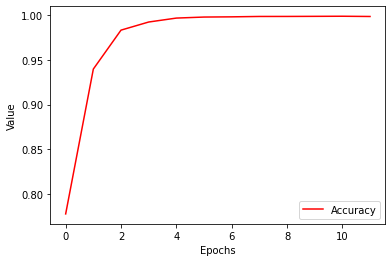

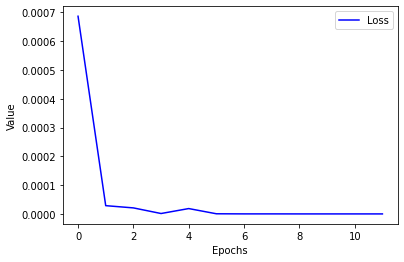

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.001707250950857997	Accuracy: 0.792025089263916
Epoch 2 Completed,	Loss 3.0270325623860117e-06	Accuracy: 0.9527590274810791
Epoch 3 Completed,	Loss 8.160507150023477e-07	Accuracy: 0.9872196912765503
Epoch 4 Completed,	Loss 4.80565688576462e-07	Accuracy: 0.9949023723602295
Epoch 5 Completed,	Loss 6.800236178605701e-07	Accuracy: 0.998106062412262
Epoch 6 Completed,	Loss 1.4556508176610805e-07	Accuracy: 0.997998833656311
Epoch 7 Completed,	Loss 3.6722781260323245e-08	Accuracy: 0.9992568492889404
Epoch 8 Completed,	Loss 1.2966414608683863e-08	Accuracy: 0.9993520975112915
Epoch 9 Completed,	Loss 3.485639776812377e-09	Accuracy: 0.9994972944259644
Epoch 10 Completed,	Loss 1.2102027824312245e-08	Accuracy: 0.9997748136520386
Epoch 11 Completed,	Loss 4.851992141396977e-09	Accuracy: 0.9998178482055664
Epoch 12 Completed,	Loss 2.1972633490463522e-08	Accuracy: 0.999535322189331


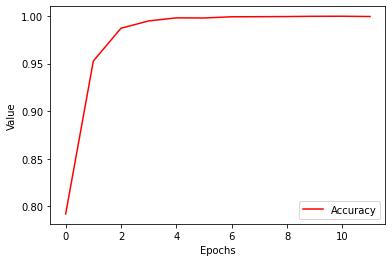

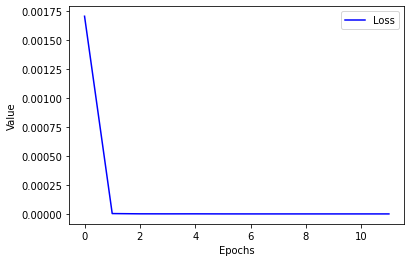

In [ ]:
path = '/content/guj_art and culture_sample1.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'art'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
name = 'art'
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Economy

/content/guj_economy_sample2.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.0006247915443964303	Accuracy: 0.8463437557220459
Epoch 2 Completed,	Loss 0.00010440866753924638	Accuracy: 0.9660144448280334
Epoch 3 Completed,	Loss 1.260828685190063e-05	Accuracy: 0.9900450706481934
Epoch 4 Completed,	Loss 0.0004397024167701602	Accuracy: 0.9951729774475098
Epoch 5 Completed,	Loss 1.2229345429659588e-06	Accuracy: 0.9977220296859741
Epoch 6 Completed,	Loss 3.163196652167244e-06	Accuracy: 0.9985265135765076
Epoch 7 Completed,	Loss 3.109240935827984e-07	Accuracy: 0.998653769493103
Epoch 8 Completed,	Loss 5.667639690898341e-09	Accuracy: 0.9990732669830322
Epoch 9 Completed,	Loss 1.6731105390022094e-09	Accuracy: 0.9989190697669983
Epoch 10 Completed,	Loss 2.216868688620366e-09	Accuracy: 0.9988970756530762
Epoch 11 Completed,	Loss 1.986817377286343e-09	Accuracy: 0.9990255832672119
Epoch 12 Completed,	Loss 1.3175731616854591e-09	Accuracy: 0.9990456104278564


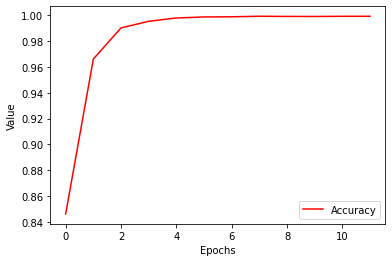

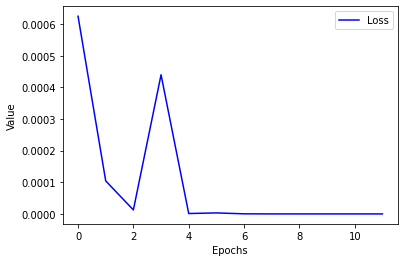

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.00016557097842451185	Accuracy: 0.8540309071540833
Epoch 2 Completed,	Loss 0.0003520851314533502	Accuracy: 0.9733545780181885
Epoch 3 Completed,	Loss 9.450876632399741e-07	Accuracy: 0.9917551875114441
Epoch 4 Completed,	Loss 1.6175184214262117e-07	Accuracy: 0.9957199692726135
Epoch 5 Completed,	Loss 2.577828865923948e-07	Accuracy: 0.9981593489646912
Epoch 6 Completed,	Loss 8.001023132919727e-08	Accuracy: 0.9998277425765991
Epoch 7 Completed,	Loss 8.260818695760008e-09	Accuracy: 0.9999999403953552
Epoch 8 Completed,	Loss 3.848122709371182e-09	Accuracy: 0.9997801780700684
Epoch 9 Completed,	Loss 8.365562409462513e-11	Accuracy: 0.9995689392089844
Epoch 10 Completed,	Loss 1.0456951277104665e-10	Accuracy: 0.9995140433311462
Epoch 11 Completed,	Loss 0.0	Accuracy: 0.9994691014289856
Epoch 12 Completed,	Loss 0.0	Accuracy: 0.9998463988304138


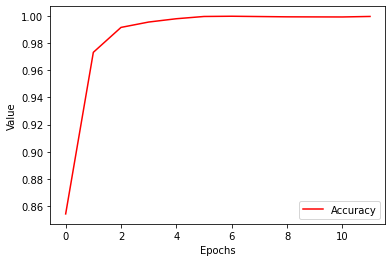

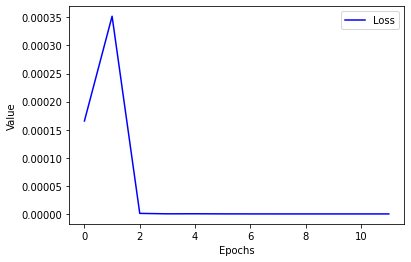

In [ ]:
path = '/content/guj_economy_sample2.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'economy'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## entertainment

/content/guj_entertainment_sample3.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.001929686637595296	Accuracy: 0.7636260390281677
Epoch 2 Completed,	Loss 0.00028021479374729097	Accuracy: 0.9362552165985107
Epoch 3 Completed,	Loss 5.392707316786982e-05	Accuracy: 0.9800167083740234
Epoch 4 Completed,	Loss 9.547429726808332e-06	Accuracy: 0.9899637699127197
Epoch 5 Completed,	Loss 3.551964709913591e-06	Accuracy: 0.9906468987464905
Epoch 6 Completed,	Loss 8.035808605200145e-07	Accuracy: 0.9936858415603638
Epoch 7 Completed,	Loss 5.331357328941522e-07	Accuracy: 0.9927866458892822
Epoch 8 Completed,	Loss 8.78966659456637e-07	Accuracy: 0.9935446381568909
Epoch 9 Completed,	Loss 2.051713323680815e-07	Accuracy: 0.9942182302474976
Epoch 10 Completed,	Loss 8.710663479405412e-08	Accuracy: 0.9937898516654968
Epoch 11 Completed,	Loss 1.5686447341067833e-07	Accuracy: 0.994592547416687
Epoch 12 Completed,	Loss 1.387443315792325e-08	Accuracy: 0.9943838119506836


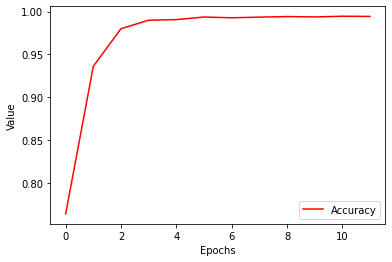

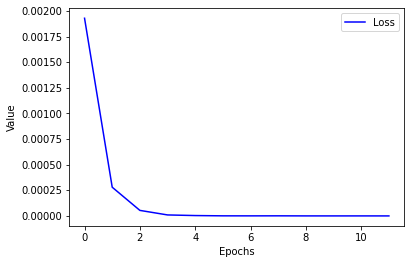

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.001434121048077941	Accuracy: 0.7743909358978271
Epoch 2 Completed,	Loss 0.0003424548194743693	Accuracy: 0.9536862373352051
Epoch 3 Completed,	Loss 4.518620698945597e-06	Accuracy: 0.9904119372367859
Epoch 4 Completed,	Loss 7.742888783468516e-07	Accuracy: 0.9960311055183411
Epoch 5 Completed,	Loss 2.1127492288997018e-07	Accuracy: 0.998180091381073
Epoch 6 Completed,	Loss 4.4781029373552883e-07	Accuracy: 0.9978950619697571
Epoch 7 Completed,	Loss 3.023240253696713e-07	Accuracy: 0.9988866448402405
Epoch 8 Completed,	Loss 4.547614196326322e-08	Accuracy: 0.9993451237678528
Epoch 9 Completed,	Loss 1.4591798880303486e-08	Accuracy: 0.9993698596954346
Epoch 10 Completed,	Loss 2.5060421293687796e-08	Accuracy: 0.9995557069778442
Epoch 11 Completed,	Loss 4.4920849973095756e-07	Accuracy: 0.9999999403953552
Epoch 12 Completed,	Loss 2.1564806829132976e-08	Accuracy: 0.999434769153595


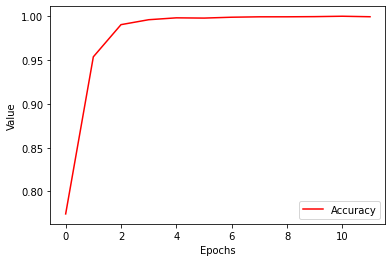

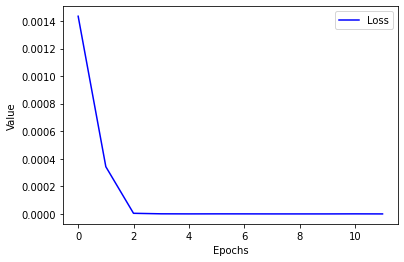

In [ ]:
path = '/content/guj_entertainment_sample3.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'entertainment'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Philosophy

/content/guj_philosophy_sample4.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.00034292537020519376	Accuracy: 0.8092136979103088
Epoch 2 Completed,	Loss 1.3092456356389448e-05	Accuracy: 0.9494040608406067
Epoch 3 Completed,	Loss 0.0003841821162495762	Accuracy: 0.9845313429832458
Epoch 4 Completed,	Loss 5.786246219940949e-07	Accuracy: 0.9944800734519958
Epoch 5 Completed,	Loss 2.0307845716160955e-07	Accuracy: 0.9971720576286316
Epoch 6 Completed,	Loss 6.57094787470669e-08	Accuracy: 0.9978321194648743
Epoch 7 Completed,	Loss 1.7200612489887135e-08	Accuracy: 0.9981949925422668
Epoch 8 Completed,	Loss 2.469056781251311e-08	Accuracy: 0.9989417195320129
Epoch 9 Completed,	Loss 2.9651612720726916e-08	Accuracy: 0.9981760382652283
Epoch 10 Completed,	Loss 1.1158127755095393e-08	Accuracy: 0.9982494711875916
Epoch 11 Completed,	Loss 1.4285794769364202e-09	Accuracy: 0.9988357424736023
Epoch 12 Completed,	Loss 6.756793458073673e-10	Accuracy: 0.99908846616745


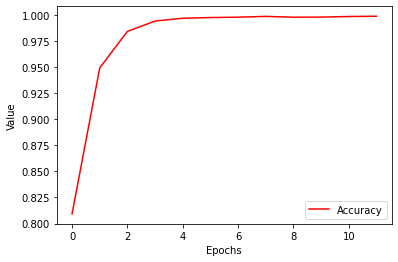

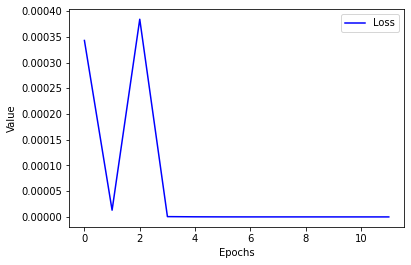

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.0010026328964158893	Accuracy: 0.7976032495498657
Epoch 2 Completed,	Loss 1.4599749192711897e-05	Accuracy: 0.9618507623672485
Epoch 3 Completed,	Loss 4.414145223563537e-06	Accuracy: 0.9924026131629944
Epoch 4 Completed,	Loss 2.2839606117486255e-07	Accuracy: 0.9968025088310242
Epoch 5 Completed,	Loss 6.826070375609561e-07	Accuracy: 0.9985057711601257
Epoch 6 Completed,	Loss 1.0155383023402464e-07	Accuracy: 0.9992862939834595
Epoch 7 Completed,	Loss 1.52894479299448e-08	Accuracy: 0.9993816614151001
Epoch 8 Completed,	Loss 5.791452206693748e-09	Accuracy: 0.9993223547935486
Epoch 9 Completed,	Loss 3.6679770332170847e-10	Accuracy: 0.9999999403953552
Epoch 10 Completed,	Loss 9.652571103524465e-11	Accuracy: 0.9996741414070129
Epoch 11 Completed,	Loss 7.722058409376231e-11	Accuracy: 0.999904215335846
Epoch 12 Completed,	Loss 7.722057715486841e-11	Accuracy: 0.9998354911804199


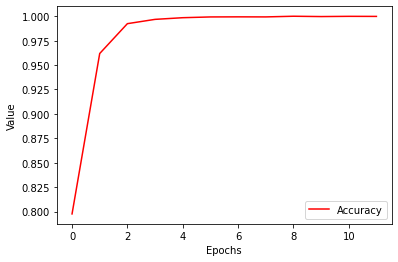

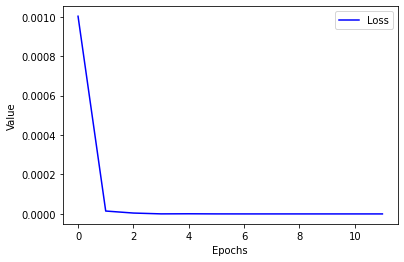

In [ ]:
path = '/content/guj_philosophy_sample4.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'philosophy'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Religion

/content/guj_religion_sample5.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.0007623497513122857	Accuracy: 0.7438837885856628
Epoch 2 Completed,	Loss 0.0027790761087089777	Accuracy: 0.9315819144248962
Epoch 3 Completed,	Loss 0.0041473740711808205	Accuracy: 0.9811176657676697
Epoch 4 Completed,	Loss 0.0027466872707009315	Accuracy: 0.9914082884788513
Epoch 5 Completed,	Loss 0.002273084130138159	Accuracy: 0.994483232498169
Epoch 6 Completed,	Loss 0.0019716834649443626	Accuracy: 0.9961198568344116
Epoch 7 Completed,	Loss 0.001924273557960987	Accuracy: 0.9967432618141174
Epoch 8 Completed,	Loss 0.00145411875564605	Accuracy: 0.9970205426216125
Epoch 9 Completed,	Loss 0.0016511146677657962	Accuracy: 0.9978523254394531
Epoch 10 Completed,	Loss 0.0012235704343765974	Accuracy: 0.9975336790084839
Epoch 11 Completed,	Loss 0.0011000536615028977	Accuracy: 0.9976442456245422
Epoch 12 Completed,	Loss 0.0011604171013459563	Accuracy: 0.9976102709770203


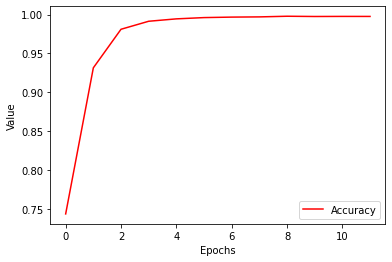

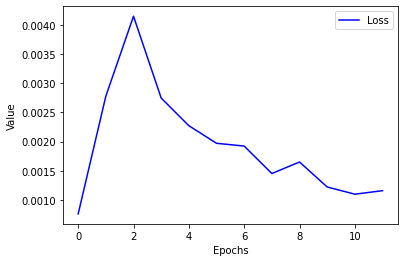

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.0008818698115646839	Accuracy: 0.7622057199478149
Epoch 2 Completed,	Loss 0.0006922192987985909	Accuracy: 0.9478344917297363
Epoch 3 Completed,	Loss 0.0013354133116081357	Accuracy: 0.9870396852493286
Epoch 4 Completed,	Loss 1.8422817049668083e-07	Accuracy: 0.9953170418739319
Epoch 5 Completed,	Loss 6.193484125560644e-08	Accuracy: 0.9978719353675842
Epoch 6 Completed,	Loss 1.3581023949882365e-07	Accuracy: 0.9993987083435059
Epoch 7 Completed,	Loss 5.174638673111076e-08	Accuracy: 0.9994427561759949
Epoch 8 Completed,	Loss 6.1235665427261665e-09	Accuracy: 0.9999578595161438
Epoch 9 Completed,	Loss 1.0289523011408619e-08	Accuracy: 0.9995051026344299
Epoch 10 Completed,	Loss 1.967535112612495e-08	Accuracy: 0.9994052648544312
Epoch 11 Completed,	Loss 5.019338070177959e-11	Accuracy: 0.9996718168258667
Epoch 12 Completed,	Loss 3.513535851151772e-10	Accuracy: 0.9993042349815369


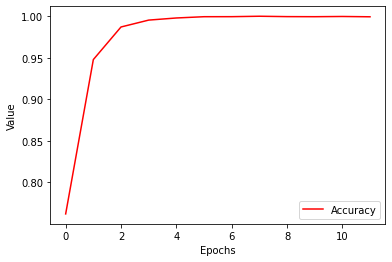

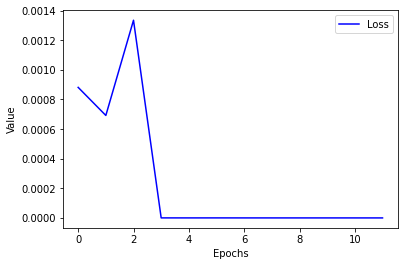

In [ ]:
path = '/content/guj_religion_sample5.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'religion'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Science

/content/guj_science and technology_sample6.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.0005439072265289724	Accuracy: 0.7618436217308044
Epoch 2 Completed,	Loss 0.0001564324920764193	Accuracy: 0.9355854988098145
Epoch 3 Completed,	Loss 2.6064217308885418e-06	Accuracy: 0.981730580329895
Epoch 4 Completed,	Loss 3.011754472481698e-07	Accuracy: 0.9925148487091064
Epoch 5 Completed,	Loss 2.020047986661666e-06	Accuracy: 0.9960373044013977
Epoch 6 Completed,	Loss 2.632130531310395e-07	Accuracy: 0.9961968660354614
Epoch 7 Completed,	Loss 2.0970740877146454e-07	Accuracy: 0.9971931576728821
Epoch 8 Completed,	Loss 4.8371457950224794e-08	Accuracy: 0.9977877140045166
Epoch 9 Completed,	Loss 3.7017535703398607e-09	Accuracy: 0.9978047013282776
Epoch 10 Completed,	Loss 3.618090493873183e-09	Accuracy: 0.9978199601173401
Epoch 11 Completed,	Loss 5.1862805605651374e-08	Accuracy: 0.9976992011070251
Epoch 12 Completed,	Loss 1.7400070717599192e-08	Accuracy: 0.9976048469543457


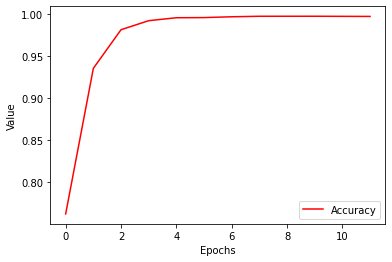

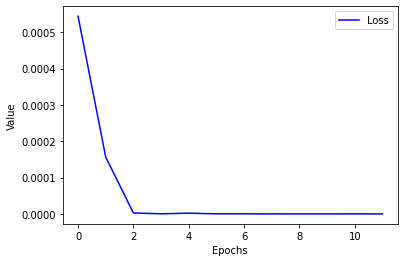

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.0007046774262562394	Accuracy: 0.7854670882225037
Epoch 2 Completed,	Loss 1.1549395821930375e-05	Accuracy: 0.9526130557060242
Epoch 3 Completed,	Loss 2.4206417492678156e-06	Accuracy: 0.9880526661872864
Epoch 4 Completed,	Loss 9.812615644477773e-07	Accuracy: 0.9951169490814209
Epoch 5 Completed,	Loss 8.188479938553428e-08	Accuracy: 0.997431218624115
Epoch 6 Completed,	Loss 1.2017706296774122e-07	Accuracy: 0.9985947608947754
Epoch 7 Completed,	Loss 1.9025841879738437e-07	Accuracy: 0.9992639422416687
Epoch 8 Completed,	Loss 1.277227568152739e-07	Accuracy: 0.9995596408843994
Epoch 9 Completed,	Loss 4.162800451013027e-06	Accuracy: 0.9987810254096985
Epoch 10 Completed,	Loss 1.212985445420145e-08	Accuracy: 0.9998497366905212
Epoch 11 Completed,	Loss 2.2796071696973286e-09	Accuracy: 0.9995419979095459
Epoch 12 Completed,	Loss 1.882246136730714e-09	Accuracy: 0.9998656511306763


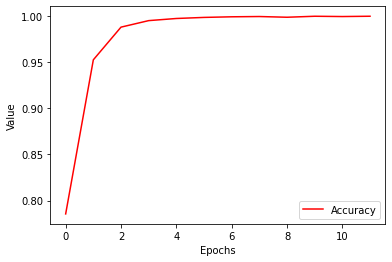

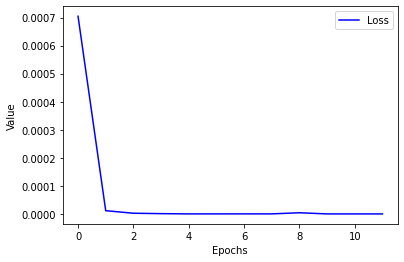

In [ ]:
path = '/content/guj_science and technology_sample6.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'Science'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sports

/content/guj_sports_sample7.txt
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.0006119079771451652	Accuracy: 0.7798768877983093
Epoch 2 Completed,	Loss 0.00021712688612751663	Accuracy: 0.9510098695755005
Epoch 3 Completed,	Loss 7.924724741315003e-06	Accuracy: 0.9842371344566345
Epoch 4 Completed,	Loss 1.2101842230549664e-06	Accuracy: 0.9925546050071716
Epoch 5 Completed,	Loss 6.928092943780939e-07	Accuracy: 0.9951483607292175
Epoch 6 Completed,	Loss 4.1838200104393763e-07	Accuracy: 0.9965034127235413
Epoch 7 Completed,	Loss 6.37609161913133e-07	Accuracy: 0.9971016645431519
Epoch 8 Completed,	Loss 3.833433837030498e-08	Accuracy: 0.9977782368659973
Epoch 9 Completed,	Loss 1.5069731773564854e-07	Accuracy: 0.9971778988838196
Epoch 10 Completed,	Loss 7.215271935478995e-09	Accuracy: 0.9973991513252258
Epoch 11 Completed,	Loss 3.952719929145587e-09	Accuracy: 0.9976769685745239
Epoch 12 Completed,	Loss 4.548752485789009e-09	Accuracy: 0.9979870915412903


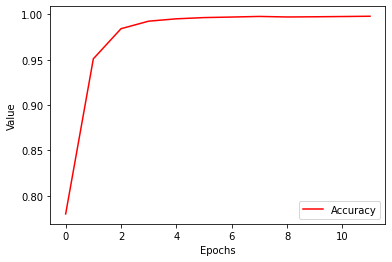

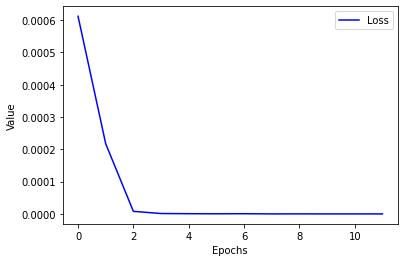

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 0.0010736488038673997	Accuracy: 0.7658998370170593
Epoch 2 Completed,	Loss 7.643418030056637e-06	Accuracy: 0.9544472694396973
Epoch 3 Completed,	Loss 3.4975710150320083e-06	Accuracy: 0.9874572157859802
Epoch 4 Completed,	Loss 1.5039740901556797e-06	Accuracy: 0.9948291182518005
Epoch 5 Completed,	Loss 1.553138986309932e-07	Accuracy: 0.9974011778831482
Epoch 6 Completed,	Loss 2.2680678668507426e-08	Accuracy: 0.9987791180610657
Epoch 7 Completed,	Loss 3.6703731165488307e-09	Accuracy: 0.9993662238121033
Epoch 8 Completed,	Loss 1.9418166630202904e-08	Accuracy: 0.9989887475967407
Epoch 9 Completed,	Loss 9.128788391876697e-09	Accuracy: 0.9990614652633667
Epoch 10 Completed,	Loss 2.101839813306583e-09	Accuracy: 0.9996938705444336
Epoch 11 Completed,	Loss 8.52837516163163e-08	Accuracy: 0.9994733333587646
Epoch 12 Completed,	Loss 8.470125711923515e-10	Accuracy: 0.9992468357086182


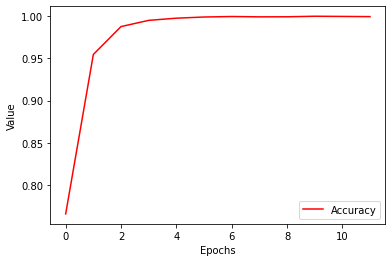

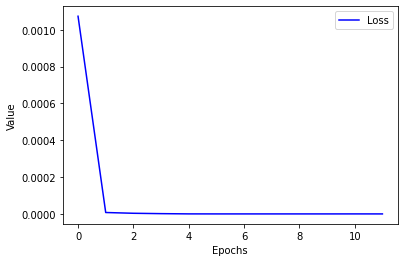

In [ ]:
path = '/content/guj_sports_sample7.txt'
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)
name = 'Sports'

mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [ ]:
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))

accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(accuracy_lstm)
print(f1score_lstm)
print(recall_lstm)
print(precision_lstm)

print(accuracy_bilstm)
print(f1score_bilstm)
print(recall_bilstm)
print(precision_bilstm)

print(final_true_bilstm)
print(final_pred_bilstm)

print(final_pred_lstm)
print(final_true_lstm)

[0.7503448275862069, 0.7721139430284858, 0.743103448275862, 0.7607655502392344, 0.7193548387096774, 0.7852437417654808, 0.7991803278688525]
[0.672735750504551, 0.6983187675479507, 0.7633197815088947, 0.6796046517668513, 0.6964519806969853, 0.8041475184357799, 0.7873760420610109]
[0.7034922271628155, 0.779588635452246, 0.7480317000812136, 0.7317183623627868, 0.7517846741069059, 0.8218111694675757, 0.7927953390450827]
[0.6808857397223548, 0.6849104244015571, 0.818353970787609, 0.6685696869200706, 0.6956457121225783, 0.8137619111437356, 0.7952004508882619]
[0.8082758620689655, 0.8125937031484258, 0.7603448275862069, 0.8452950558213717, 0.7258064516129032, 0.7773386034255599, 0.8210382513661202]
[0.7916167682566392, 0.7535128094017941, 0.7758613469253751, 0.8468644621585057, 0.7585103638558428, 0.7663855975027575, 0.8258309621302864]
[0.7969253957734349, 0.756475616838638, 0.7543386012743557, 0.8368871757115585, 0.7571974699740758, 0.8232275230496294, 0.8229385710052509]
[0.807706266891088

# LSTM on Complete data

In [9]:
final_true_lstm = {}
final_pred_lstm = {}
final_pred_bilstm = {}
final_true_bilstm = {}

In [10]:
def data_loader(path):
  tagged_sentence = []
  for i in path:
    tagged = process_file(i)
    tagged_sentence.extend(tagged)

  print(len(tagged_sentence))
  
  word_to_idx,tag_to_idx,char_to_idx = idgenerate(tagged_sentence)
  tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))
  train = [tagged_sentence[i] for i in tr_random]
  test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

  return train,test,word_to_idx,tag_to_idx,char_to_idx

7000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 2.2395906853489578e-05	Accuracy: 0.8666582703590393
Epoch 2 Completed,	Loss 8.18687658465933e-06	Accuracy: 0.9462278485298157
Epoch 3 Completed,	Loss 8.23573827801738e-06	Accuracy: 0.973628044128418
Epoch 4 Completed,	Loss 2.1749549432570348e-06	Accuracy: 0.9840661287307739
Epoch 5 Completed,	Loss 1.7497544604339055e-06	Accuracy: 0.9892793893814087
Epoch 6 Completed,	Loss 6.385646884154994e-06	Accuracy: 0.9908562302589417
Epoch 7 Completed,	Loss 1.335721663053846e-06	Accuracy: 0.992199718952179
Epoch 8 Completed,	Loss 3.995409315393772e-06	Accuracy: 0.9932491183280945
Epoch 9 Completed,	Loss 1.7221719872395624e-06	Accuracy: 0.9937040209770203
Epoch 10 Completed,	Loss 3.887921096179525e-08	Accuracy: 0.9943640828132629
Epoch 11 Completed,	Loss 1.7079782992368564e-06	Accuracy: 0.9944480061531067
Epoch 12 Completed,	Loss 9.636785307520768e-07	Accuracy: 0.9948101043701172


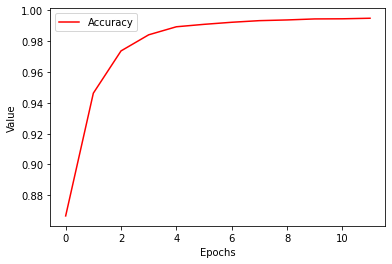

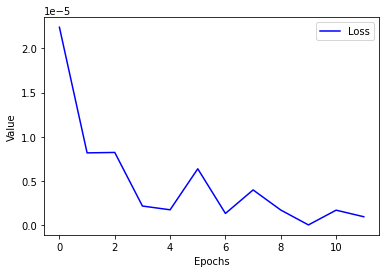

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [13]:
path = ['/content/guj_art and culture_sample1.txt','/content/guj_economy_sample2.txt','/content/guj_entertainment_sample3.txt','/content/guj_philosophy_sample4.txt','/content/guj_religion_sample5.txt','/content/guj_science and technology_sample6.txt','/content/guj_sports_sample7.txt']
train,test,word_to_idx,tag_to_idx,char_to_idx = data_loader(path)

name = 'lstm'
mod = 'lstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_lstm[name] = y_true
final_pred_lstm[name] = y_pred

In [22]:
name = 'lstm'
accuracy_lstm = []
f1score_lstm = []
recall_lstm = []
precision_lstm = []
accuracy_lstm.append(accuracy_score(final_true_lstm[name], final_pred_lstm[name]))
recall_lstm.append(recall_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
precision_lstm.append(precision_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
f1score_lstm.append(f1_score(final_true_lstm[name], final_pred_lstm[name],average='macro'))
print(accuracy_lstm)
print(f1score_lstm)
print(recall_lstm)
print(precision_lstm)

[0.7797804019059458]
[0.7375840388294806]
[0.7384760035080238]
[0.7813691554721497]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 1.416192390024662e-05	Accuracy: 0.870383083820343
Epoch 2 Completed,	Loss 2.6688241632655263e-05	Accuracy: 0.9546180963516235
Epoch 3 Completed,	Loss 1.3879283642381779e-06	Accuracy: 0.9819443821907043
Epoch 4 Completed,	Loss 1.506612932189455e-07	Accuracy: 0.9902970194816589
Epoch 5 Completed,	Loss 2.0781847354101046e-07	Accuracy: 0.9931082725524902
Epoch 6 Completed,	Loss 4.986810964169308e-08	Accuracy: 0.995000958442688
Epoch 7 Completed,	Loss 9.887632046456929e-08	Accuracy: 0.9959578514099121
Epoch 8 Completed,	Loss 8.352614599971275e-08	Accuracy: 0.9963725805282593
Epoch 9 Completed,	Loss 1.1085114692832576e-06	Accuracy: 0.9967451095581055
Epoch 10 Completed,	Loss 1.8045470673300201e-09	Accuracy: 0.997488796710968
Epoch 11 Completed,	Loss 4.887674709408429e-09	Accuracy: 0.997685968875885
Epoch 12 Completed,	Loss 3.483447530427952e-09	Accuracy: 0.9977099895477295


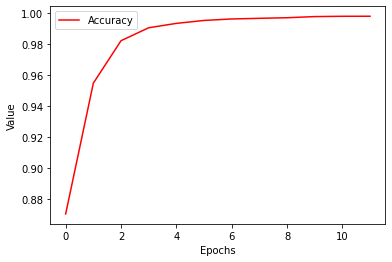

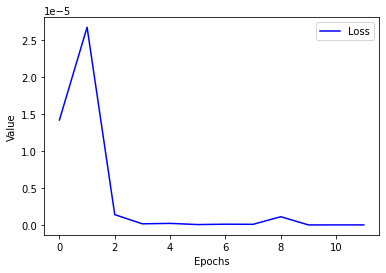

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [14]:
name = 'bilstm'
mod = 'bilstm'
opt = 'ADAM'
model= trainmodel(mod,opt,train,word_to_idx,tag_to_idx,char_to_idx)
save(model,'/content/model',mod,opt,name)
y_true,y_pred,predicted_sent = testmodel(model,test,word_to_idx,tag_to_idx,char_to_idx)
final_true_bilstm[name] = y_true
final_pred_bilstm[name] = y_pred

In [21]:
name = 'bilstm'
accuracy_bilstm = []
f1score_bilstm = []
recall_bilstm = []
precision_bilstm = []
accuracy_bilstm.append(accuracy_score(final_true_bilstm[name], final_pred_bilstm[name]))
recall_bilstm.append(recall_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
precision_bilstm.append(precision_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
f1score_bilstm.append(f1_score(final_true_bilstm[name], final_pred_bilstm[name],average='macro'))
print(accuracy_bilstm)
print(f1score_bilstm)
print(recall_bilstm)
print(precision_bilstm)

[0.7961466749533872]
[0.7864246030067286]
[0.7976236375644992]
[0.7961998649354254]
